# lesson_3_DAN_CNN_RNN_Word2Vec_Embeddings_Classifier_plus_Attention

**Description:** Text classification on the IMDB movie dataset using i) Deep Averaging Networks, and ii) Convolutions Neural Nets (CNN) and pre-trained Word2Vec word embeddings.<br>

Section 1 deals with setup and prerequisites, can does not deserve a lot of discussion. 
Data acquisition and preparation are handled in section 2, and section 3 looks at DANs and CNNs and now RNNs.


<a id = 'returnToTop'></a>

## Notebook Contents
  * 1. [Setup](#setup) 
  * 2. [Creation of the Dataset](#creationOfDataset)  
  * 3. [Modeling](#modeling)
    * 3.1 [Averaging Network](#averagingNetwork)
    * 3.2 [Deep Averaging Network (DAN)](#modelDAN)
    * 3.3 [Convolutional Neural Net (CNN)](#modelCNN)
    * 3.4 [Recurrent Neural Net (RNN)](#modelRNN)
       * 3.4.2 [Class Exercise](#classExercise)
  * 4. [What about Attention](#modelAttention)
  * 5. [Answers](#answers)
  
  
  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2023-fall-main/blob/master/materials/lesson_notebooks/lesson_3_adding_RNNs_and_attention_to_classification_notebook.ipynb)

[Return to Top](#returnToTop)  
<a id = 'setup'></a>
## 1. Setup

This notebook requires the tensorflow dataset and other prerequisites that you must download and then store locally. 

More importantly, if you want to run this notebook on your GCP instance (rather than on Colab) you will need to install a gcc compiler.  It should have been installed as part of your instance setup. In case it hasn't, the best way of doing that is to run the following command in a terminal for your instance:

``sudo apt install build-essential``

This will install the gcc package in addition to some other libraries that you might need to compile and build C and C++ based software.

Again on your GCP instance only you also need to explicitly install graphviz in order to print some plots.  

``sudo apt-get install graphviz``

In [1]:
!pip install gensim --quiet

In [2]:
!pip install tensorflow-datasets --quiet

In [3]:
!pip install -U tensorflow-text --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 95.2 MB/s eta 0:00:00


pydot is also required, along with **graphviz**.

In [4]:
!pip install pydot --quiet

Ready to do the imports.

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re


import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

Below is a helper function to plot histories.

In [6]:
# 4-window plot of loss and accuracy for two models, for comparison

def make_plot(axs,
              model_history1, 
              model_history2, 
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

Next, we get the word2vec model from nltk.

In [7]:
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [8]:
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

In [9]:
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

How many words are in the vocabulary?

In [10]:
len(model)

43981

How do the word vectors look like? As expected:

In [11]:
model['great']

array([ 3.06035e-02,  8.86877e-02, -1.21269e-02,  7.61965e-02,
        5.66269e-02, -4.24702e-02,  4.10129e-02, -4.97567e-02,
       -3.64328e-03,  6.32889e-02, -1.42608e-02, -7.91111e-02,
        1.74877e-02, -3.83064e-02,  9.26433e-03,  2.95626e-02,
        7.70293e-02,  9.49334e-02, -4.28866e-02, -2.95626e-02,
        4.45244e-05,  6.82854e-02,  1.73836e-02,  3.14363e-02,
        6.53708e-02,  2.89380e-02, -4.39275e-02,  1.78000e-02,
        1.82164e-02, -4.70503e-02, -2.85216e-02,  1.79041e-02,
        1.06592e-01,  9.07696e-02,  6.78690e-02,  6.16755e-03,
       -2.08187e-02,  5.95936e-03,  1.51586e-03,  8.95205e-02,
        6.49544e-02, -3.12281e-02,  9.24351e-02, -2.45661e-02,
       -1.21269e-02, -1.53538e-03,  6.49544e-02, -1.12421e-02,
        9.10819e-03, -6.45380e-02,  4.43439e-02,  1.35738e-01,
       -7.91111e-02,  1.57181e-02, -4.72585e-02, -1.35322e-02,
       -4.33029e-02, -5.16304e-02,  1.37404e-01, -3.12281e-02,
       -6.49544e-02,  1.14087e-01, -6.41217e-02, -5.246

We can now build the embedding matrix and a vocabulary dictionary:

In [12]:
EMBEDDING_DIM = len(model['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:  
embedding_matrix = np.zeros((len(model) + 1, EMBEDDING_DIM))  
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(model.index_to_key):
    embedding_vector = model[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [13]:
embedding_matrix.shape

(43982, 300)

In [14]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

[Return to Top](#returnToTop)  
<a id = 'creationOfDataset'></a>
## 2. Creation of the Dataset

### 2.1 Data Acquisition

We will use the IMDB dataset delivered as part of the tensorflow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [15]:
train_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTFO4KQ/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTFO4KQ/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteTFO4KQ/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [16]:
train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

In [17]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [18]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

Next, we tokenize the data:

In [19]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Does this look right?

In [20]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Yup... looks right. Of course we will need to take care of the encoding later.

### 2.2 Data Preparation

For the models we will use, we need to define a maximum sequence length (max number of tokens per movie review that we'll feed into our model). We'll cut off any tokens longer than that, and we'll pad shorter movie reviews with zeros at the end.

In [21]:
MAX_SEQUENCE_LENGTH = 128

Next, we define a simple function that converts the tokens of each movie review into their word2vec vocabulary index values.   

In [22]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])
            
        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with uknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding

        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)
            
        if i % 5000 == 0:
            print('Examples processed: ', i)
        
    print('Total examples: ', i)

    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.

In [23]:
train_input = docs_to_vocab_ids(train_tokens)
test_input = docs_to_vocab_ids(test_tokens)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Total examples:  19999
Examples processed:  0
Total examples:  4999


Let's convince ourselves that the data looks correct.  We expect the train data to be an array of integer ids and the labels to be an array of zeroes and ones (since we are learning a binary classifier).

In [24]:
train_input[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958,  5589,  8092, 43981, 34516, 43981,  8092, 16182, 43981,
        39933, 43981, 12139,  2326, 32781, 32467,  7046, 43981, 43981,
        43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981, 43981,
      

In [25]:
train_labels[:4]

array([0, 0, 0, 1])

[Return to Top](#returnToTop)  
<a id = 'modeling'></a>
## 3. Modeling

<a id = 'averagingNetwork'></a>
### 3.1 Averaging Network (AN) Model

Let us start by defining the embedding layer, then we'll average the embeddings and pass them into our classification layer.

In [26]:
an_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')

In [27]:
an_embedding_layer = Embedding(embedding_matrix.shape[0],
                               embedding_matrix.shape[1],
                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False)

In [28]:
an_embeddings = an_embedding_layer(an_input_layer)

Now lets define a layer that will take the embeddings for each of the words in an input sentence and create one averaged embedding to represent the sentence. 

In [29]:
an_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(an_embeddings)

Finally lets define our output layer.

In [30]:
an_classification = tf.keras.layers.Dense(1, 
                                          activation='sigmoid', 
                                          name='an_classification')(an_avg_embeddings)

In [31]:
an_model = tf.keras.models.Model(inputs=an_input_layer, outputs=[an_classification])

In [32]:
an_model.compile(loss='binary_crossentropy',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                    beta_1=0.9,
                                                    beta_2=0.999,
                                                    epsilon=1e-07,
                                                    amsgrad=False,
                                                    name='Adam'),
                 metrics='accuracy')

In [33]:
an_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 300)          13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 an_classification (Dense)   (None, 1)                 301       
                                                                 
Total params: 13,194,901
Trainable params: 301
Non-trainable params: 13,194,600
_________________________________________________________________


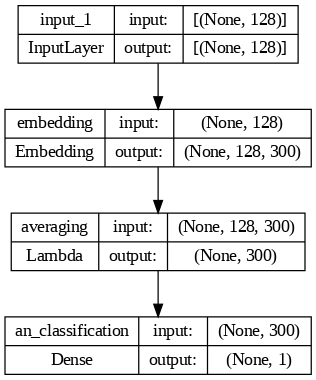

In [34]:
keras.utils.plot_model(an_model, show_shapes=True, dpi=90)

Let's look at the predictions and labels before training. Do those make sense?

In [35]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

1/1 [==============================] - 3s 3s/step
predictions:
 [[0.50023514]
 [0.5009692 ]
 [0.5014394 ]
 [0.49777183]
 [0.499096  ]]


labels:
 [0 0 0 1 1]


In [36]:
an_history = an_model.fit(train_input,
                          train_labels,
                          validation_data=(test_input, test_labels),
                          batch_size=32,
                          epochs=20
                          )

Epoch 1/20
625/625 [==============================] - 4s 3ms/step - loss: 0.6886 - accuracy: 0.5587 - val_loss: 0.6846 - val_accuracy: 0.6090
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6787 - accuracy: 0.6447 - val_loss: 0.6763 - val_accuracy: 0.6442
Epoch 3/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6701 - accuracy: 0.6640 - val_loss: 0.6693 - val_accuracy: 0.6510
Epoch 4/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6624 - accuracy: 0.6686 - val_loss: 0.6629 - val_accuracy: 0.6578
Epoch 5/20
625/625 [==============================] - 2s 4ms/step - loss: 0.6555 - accuracy: 0.6699 - val_loss: 0.6568 - val_accuracy: 0.6594
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6492 - accuracy: 0.6783 - val_loss: 0.6512 - val_accuracy: 0.6658
Epoch 7/20
625/625 [==============================] - 2s 3ms/step - loss: 0.6434 - accuracy: 0.6823 - val_loss: 0.6461 - val_accuracy: 0.6724
Epoch 

Let's revisit the predictions. How is this?

In [37]:
print('predictions:\n', an_model.predict(train_input[:5]))
print('\n\nlabels:\n', train_labels[:5])

1/1 [==============================] - 0s 27ms/step
predictions:
 [[0.33478034]
 [0.31908333]
 [0.6043128 ]
 [0.6346503 ]
 [0.5333501 ]]


labels:
 [0 0 0 1 1]


That learned somewhat, can we do better?

[Return to Top](#returnToTop)  
<a id = 'modelDAN'></a>
### 3.2. Deep Averaging Network (DAN)

Now let's add some hidden layers after the averaging layer, to give our model more depth. The first and last layers are the same as above.

We'll also put our model creation code into a function, with variables for the things we can change (in this case, the hidden layers). Then we can try different values later.

In [38]:
def build_dan_model(hidden_layer_dims, dropout_rate, embeddings_trainable=False):
    dan_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1),
                                                name='averaging')(dan_embeddings)
    last_hidden_output = dan_avg_embeddings

    for i, h_dim in enumerate(hidden_layer_dims):
        last_hidden_output = tf.keras.layers.Dense(h_dim, activation='relu',
                                                   name='dan_hidden_%d' % i)(last_hidden_output)
        last_hidden_output = tf.keras.layers.Dropout(dropout_rate)(last_hidden_output)
    
    dan_classification = tf.keras.layers.Dense(1,
                                               activation='sigmoid',
                                               name='dan_classification')(last_hidden_output)
    
    dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
    dan_model.compile(loss='binary_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                         beta_1=0.9,
                                                         beta_2=0.999,
                                                         epsilon=1e-07,
                                                         amsgrad=False,
                                                         name='Adam'),
                      metrics='accuracy')
    return dan_model

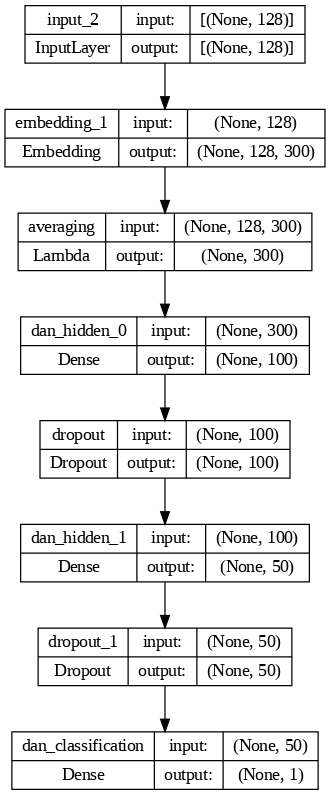

In [39]:
# Now call our function to create a DAN model, and show the model diagram

hidden_layer_sizes = [100, 50]
dropout_rate = 0.5

dan_model = build_dan_model(hidden_layer_sizes, dropout_rate)
keras.utils.plot_model(dan_model, show_shapes=True, dpi=90)

In [40]:
dan_history = dan_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=20
                            )

Epoch 1/20
625/625 [==============================] - 4s 3ms/step - loss: 0.6379 - accuracy: 0.6291 - val_loss: 0.5418 - val_accuracy: 0.7360
Epoch 2/20
625/625 [==============================] - 2s 3ms/step - loss: 0.5299 - accuracy: 0.7423 - val_loss: 0.5077 - val_accuracy: 0.7538
Epoch 3/20
625/625 [==============================] - 3s 4ms/step - loss: 0.5056 - accuracy: 0.7585 - val_loss: 0.5187 - val_accuracy: 0.7442
Epoch 4/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4993 - accuracy: 0.7605 - val_loss: 0.4857 - val_accuracy: 0.7630
Epoch 5/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4897 - accuracy: 0.7678 - val_loss: 0.4839 - val_accuracy: 0.7670
Epoch 6/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4843 - accuracy: 0.7703 - val_loss: 0.4947 - val_accuracy: 0.7558
Epoch 7/20
625/625 [==============================] - 2s 3ms/step - loss: 0.4789 - accuracy: 0.7717 - val_loss: 0.4939 - val_accuracy: 0.7602
Epoch 

Below is a sample plot for two different models:

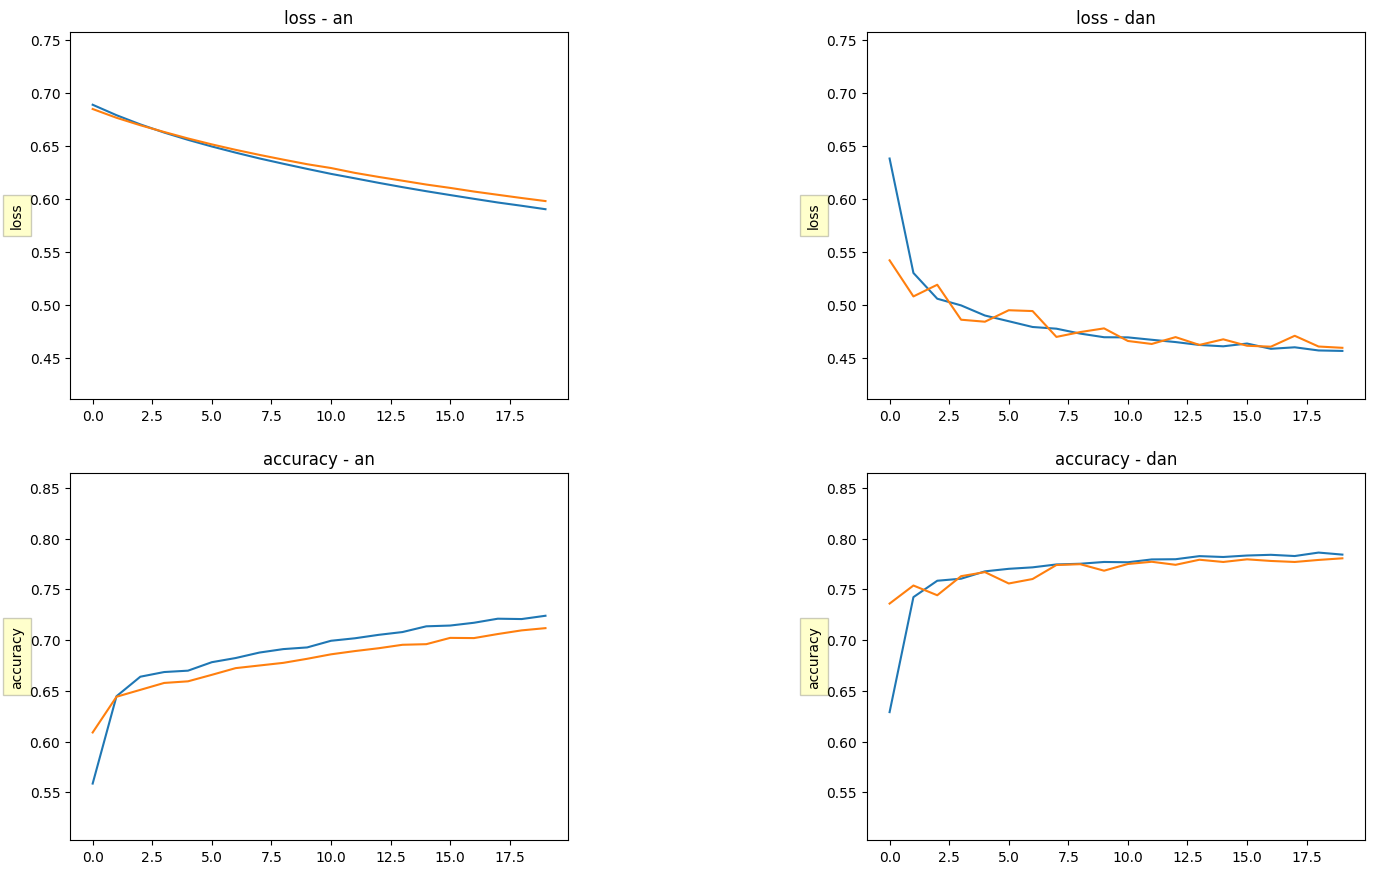

In [41]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          an_history,
          dan_history,
          model_1_name='an',
          model_2_name='dan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

Of course, the avergaing network is not done training.

[Return to Top](#returnToTop)  
<a id = 'modelCNN'></a>
### 3.3 CNN Model

Next let's build a CNN model. We'll also wrap the model building code in a function that takes some hyperparameters, so that we can adjust things like number of filters and filter sizes later.

In [42]:
def build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    cnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    cnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    cnn_embeddings = cnn_embedding_layer(cnn_input_layer)

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_embeddings)
        conv_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)
    
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(conv_output)

    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
    
    cnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    cnn_model = keras.Model(inputs=cnn_input_layer, outputs=cnn_prediction)
    cnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return cnn_model

In [43]:
# Now specify model hyperparameters and call the function to create a CNN model

num_filters = [100, 100, 50, 25]
kernel_sizes = [3, 4, 5, 10]
dense_layer_dims = [100, 50]
dropout_rate = 0.5

cnn_model = build_cnn_model(num_filters, kernel_sizes, dense_layer_dims, dropout_rate)

In [44]:
cnn_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 128, 300)     13194600    ['input_3[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 126, 100)     90100       ['embedding_2[0][0]']            
                                                                                                  
 conv1d_1 (Conv1D)              (None, 125, 100)     120100      ['embedding_2[0][0]']            
                                                                                            

The keras plot utility shows this probably a bit nicer:

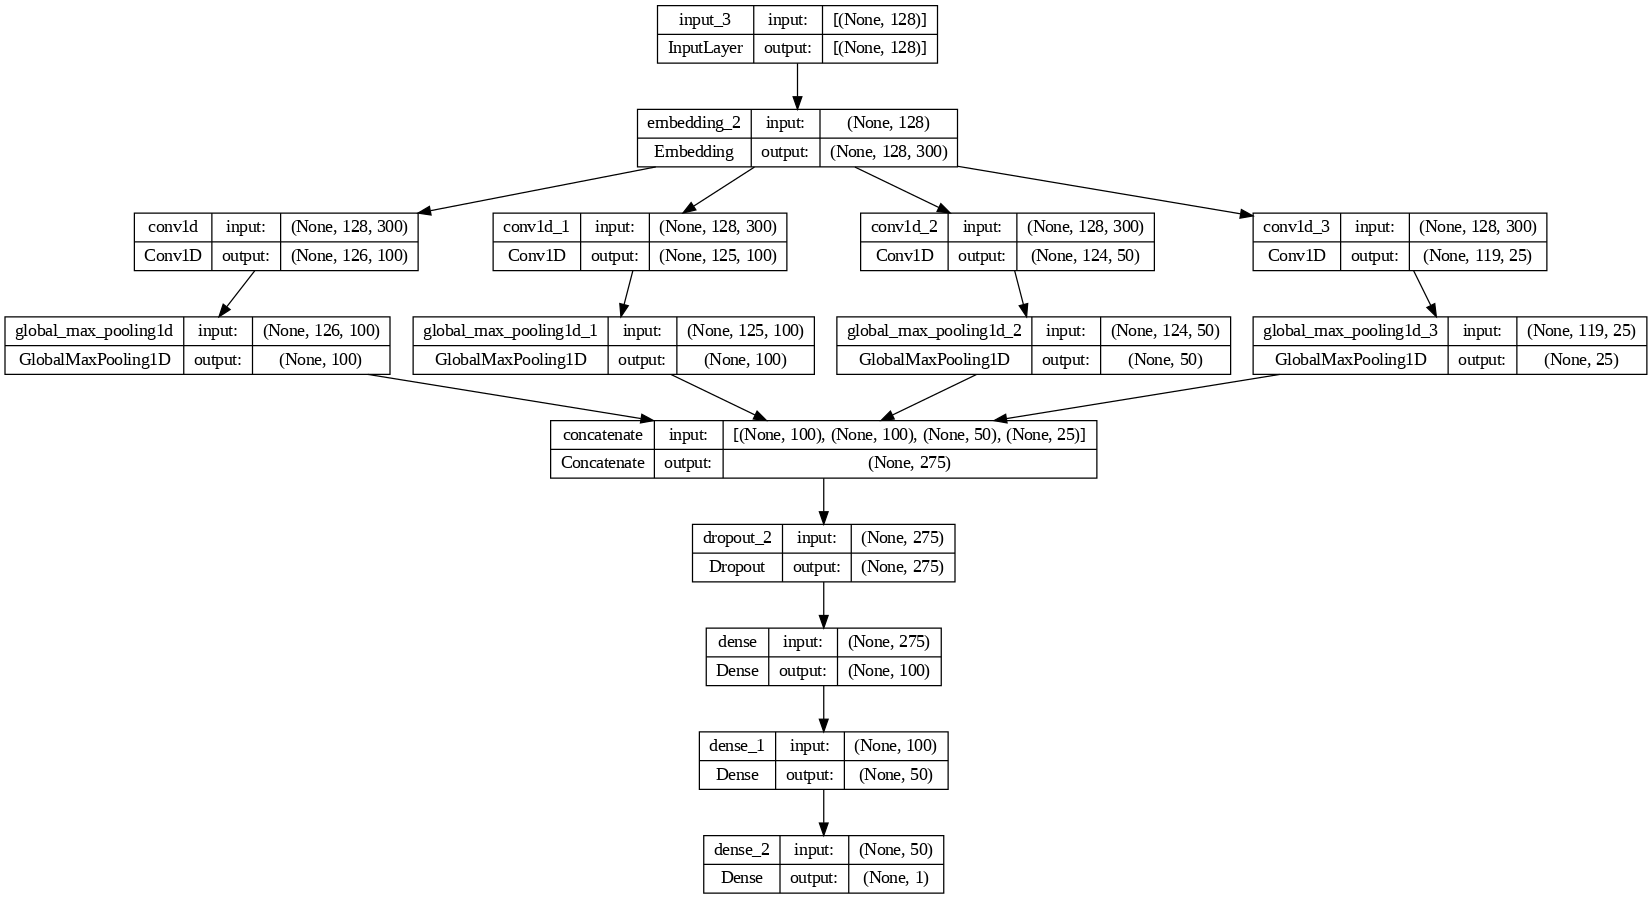

In [45]:
keras.utils.plot_model(cnn_model, show_shapes=True, dpi=90)

In [46]:
cnn_history = cnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
625/625 [==============================] - 12s 6ms/step - loss: 0.5509 - accuracy: 0.6974 - val_loss: 0.4761 - val_accuracy: 0.7712
Epoch 2/5
625/625 [==============================] - 4s 7ms/step - loss: 0.4306 - accuracy: 0.7998 - val_loss: 0.4116 - val_accuracy: 0.8176
Epoch 3/5
625/625 [==============================] - 4s 6ms/step - loss: 0.3727 - accuracy: 0.8334 - val_loss: 0.4055 - val_accuracy: 0.8180
Epoch 4/5
625/625 [==============================] - 4s 6ms/step - loss: 0.3258 - accuracy: 0.8604 - val_loss: 0.4018 - val_accuracy: 0.8182
Epoch 5/5
625/625 [==============================] - 4s 7ms/step - loss: 0.2817 - accuracy: 0.8820 - val_loss: 0.4806 - val_accuracy: 0.7858


Below is a comparison of a CNN model with a DAN model: 

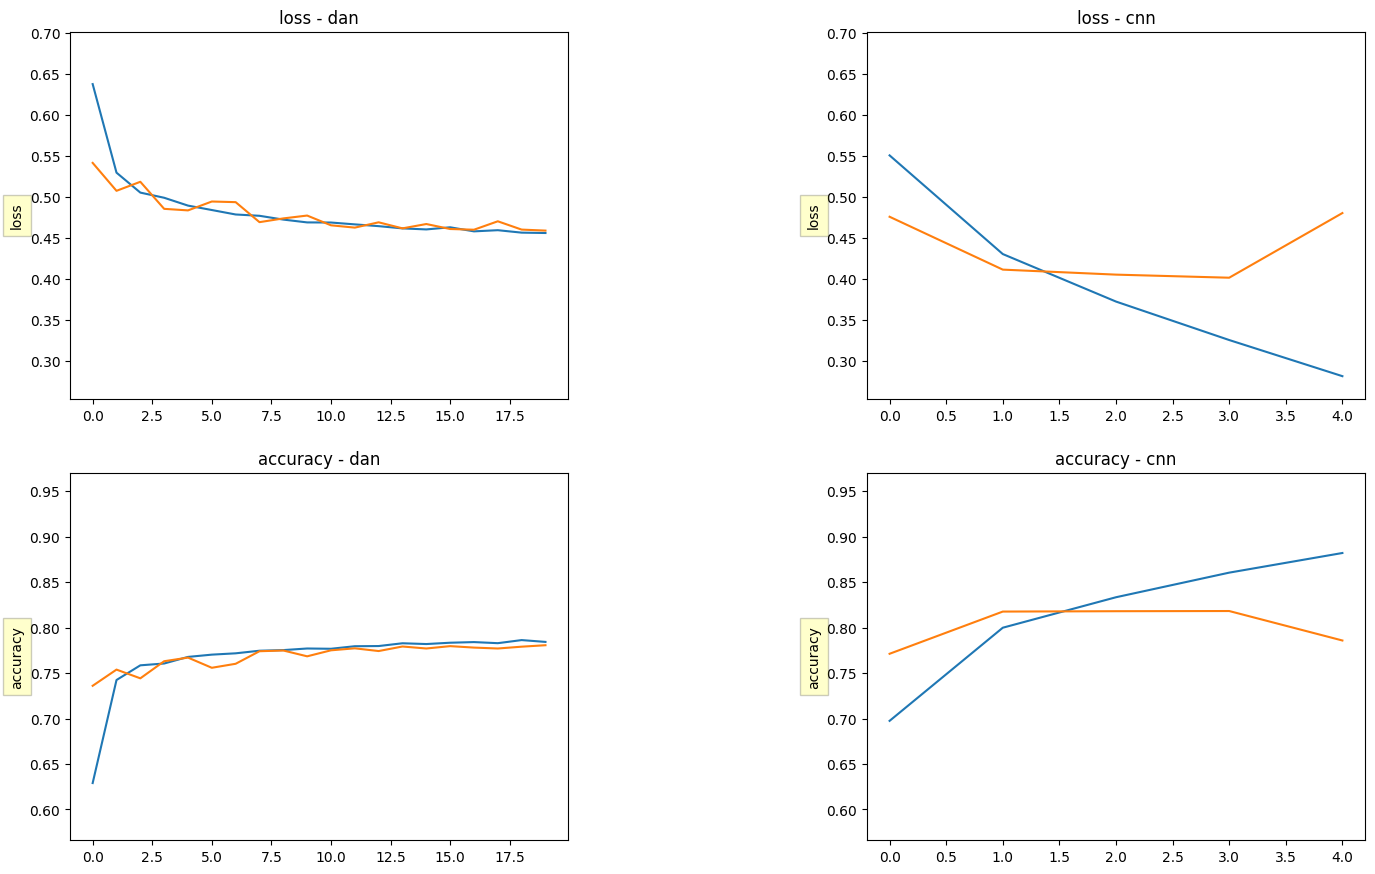

In [47]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          dan_history, 
          cnn_history, 
          model_1_name='dan',
          model_2_name='cnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

[Return to Top](#returnToTop)  
<a id = 'modelRNN'></a>
### 3.4 Recurrent Neural Network (RNN)

We now will now look at RNNs. We will first use a simple example to look at the structure of the model, and then use it also for classification of the same dataset that we used above.

#### 3.4.1. Basic Tests 

Here is a very simple LSTM model with Keras.  For more details on much more complex uses of RNNs, see [this Keras guide](https://keras.io/guides/working_with_rnns/).

In [48]:
def build_basic_rnn_model(max_length, 
                          rnn_dim,
                          return_sequences,
                          return_state):
    """
    max_length:         maximum input length
    rnn_dim:            dimension of the rnn 
    return_sequences:   should the entire sequence of output vectors for each time step be returned?  
    return_state:       should the final cell states get returned?
    """
    
    # inputs - comprised of - for each example in mini-batch:
    #             - (<max_length>) x_t, each of dim <rnn_dim>, 
    #.            - the initial 2 x 3d state (h and c) 
    
    in_x = tf.keras.layers.Input(shape=(max_length, rnn_dim), name="in_id")
    in_state_h = tf.keras.layers.Input(shape=(rnn_dim,), name="in_state_h")
    in_state_c = tf.keras.layers.Input(shape=(rnn_dim,), name="in_state_c")
    
    # define a very simple lstm layer, acting on the input
    
    lstm_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=return_sequences, return_state=return_state)\
            (in_x, initial_state=[in_state_h, in_state_c])

    model = tf.keras.models.Model(inputs=[in_x, in_state_h, in_state_c], outputs=lstm_output)
    
    return model

In [49]:
basic_rnn_model = build_basic_rnn_model(max_length=4, 
                                        rnn_dim=3,
                                        return_sequences=True,
                                        return_state=True)

In [50]:
basic_rnn_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_id (InputLayer)             [(None, 4, 3)]       0           []                               
                                                                                                  
 in_state_h (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 in_state_c (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 4, 3),       84          ['in_id[0][0]',                  
                                 (None, 3),                       'in_state_h[0][0]',       

**Questions:**

- do the output shapes look correct?
- is '84' the correct number of parameters? 
- how do we calculate that number?



Recurrent neural nets have multiple inputs and outputs.  We can put these recurrent networks together in interesting sequences.  Here are four different such configurations:

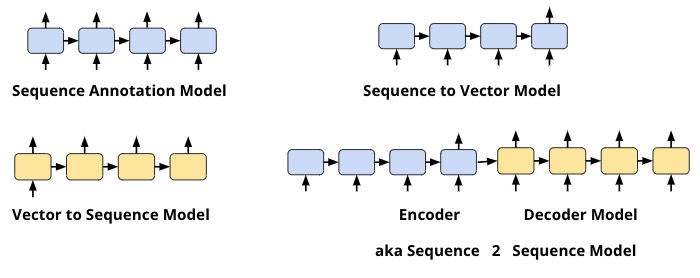

[Return to Top](#returnToTop)  
<a id = 'classExercise'></a>

#### 3.4.2 Class Exercise
For each of the four sequence types, what kinds of NLP tasks can be modeled?

The **Sequence Annotation Model** takes an input at each time step and produces an output at each timestep. What kind of language processing task(s) can be modeled with this approach?

The **Sequence to Vector Model** takes an input at each timestep but only produces a final vector representing what was seen in the entire input sequence. What kind of language processing task(s) can be modeled with this approach?

The **Vector to Sequence Model** takes one input and then uses that to generate a sequence of outputs. What kind of language processing task(s) can be modeled with this approach?

The **Sequence to Sequence Model** (also known as an encoder-decoder model) reads in one sequence, produces a final vector representation of that first sequence, and uses that to generate a new sequence.  What kind of language processing task(s) can be modeled with this approach?

We can architect these sequences by modifying two arguments *return_sequences* and *return_state*. What would change if return_sequences is false, and what about return_state?

In [51]:
basic_rnn_model_no_return_sequence = build_basic_rnn_model(max_length=4, 
                                                           rnn_dim=3,
                                                           return_sequences=False,
                                                           return_state=True)

In [52]:
basic_rnn_model_no_return_sequence.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_id (InputLayer)             [(None, 4, 3)]       0           []                               
                                                                                                  
 in_state_h (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 in_state_c (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, 3),          84          ['in_id[0][0]',                  
                                 (None, 3),                       'in_state_h[0][0]',       

In [53]:
basic_rnn_model_no_return_state = build_basic_rnn_model(max_length=4, 
                                                        rnn_dim=3,
                                                        return_sequences=True,
                                                        return_state=False)

In [54]:
basic_rnn_model_no_return_state.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_id (InputLayer)             [(None, 4, 3)]       0           []                               
                                                                                                  
 in_state_h (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 in_state_c (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 4, 3)         84          ['in_id[0][0]',                  
                                                                  'in_state_h[0][0]',       

In [55]:
basic_rnn_model_no_return_state_no_sequences = build_basic_rnn_model(max_length=4, 
                                                                     rnn_dim=3,
                                                                     return_sequences=False,
                                                                     return_state=False)

In [56]:
basic_rnn_model_no_return_state_no_sequences.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_id (InputLayer)             [(None, 4, 3)]       0           []                               
                                                                                                  
 in_state_h (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 in_state_c (InputLayer)        [(None, 3)]          0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 3)            84          ['in_id[0][0]',                  
                                                                  'in_state_h[0][0]',       

Does this look right? It does...

What about the output using toy inputs?

In [57]:
lstm_input = np.array([[[1.1,2,3], [4,5,6], [7,8,9], [10,11,12]]])
initial_h = np.array([[1.,4,3]]*1)
initial_c = np.array([[1,2,6]]*1)

out, state_h, state_c = basic_rnn_model.predict([lstm_input, initial_h, initial_c],
                                                batch_size=4)

print('output_vector', out)
print('out_state_h ', state_h)
print('out_state_c ', state_c)

1/1 [==============================] - 1s 815ms/step
output_vector [[[-4.2724935e-03  7.8516543e-01 -2.8531563e-03]
  [-7.4710543e-03  8.0937815e-01 -7.6308526e-05]
  [-5.9252995e-04  6.7919362e-01 -1.8006088e-07]
  [-4.5321303e-05  4.8671141e-02 -4.1453427e-10]]]
out_state_h  [[-4.5321303e-05  4.8671141e-02 -4.1453427e-10]]
out_state_c  [[-2.6947999e-01  5.4742668e-02 -3.9600734e-05]]


Looks correct.

#### 3.4.2. RNN for IMBD Classification

Now let's build the full RNN model we'll use for our sentiment classification problem. From the LSTM layer, we'll only use the output from the last timestep (after processing all tokens). In this task, we don't have labels for every token, just for the text as a whole.

In [58]:
def build_rnn_model(rnn_dim, dense_layer_dims, dropout_rate, embeddings_trainable=False):
    rnn_input_layer = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int64')
    rnn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=embeddings_trainable)
    rnn_embeddings = rnn_embedding_layer(rnn_input_layer)

    # only return the last output from the RNN calculation 
    rnn_output = tf.keras.layers.LSTM(rnn_dim, return_sequences=False, return_state=False, name='LSTM')\
        (rnn_embeddings)
    last_hidden_output = rnn_output
    
    for dense_layer_dim in dense_layer_dims:
        last_hidden_output = keras.layers.Dense(dense_layer_dim, activation='relu')(last_hidden_output)
        last_hidden_output = keras.layers.Dropout(rate=dropout_rate)(last_hidden_output)
    
    rnn_prediction = keras.layers.Dense(1, activation='sigmoid')(last_hidden_output)

    rnn_model = keras.Model(inputs=rnn_input_layer, outputs=rnn_prediction)
    rnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',  # From information theory notebooks.
                      metrics=['accuracy'])
    return rnn_model

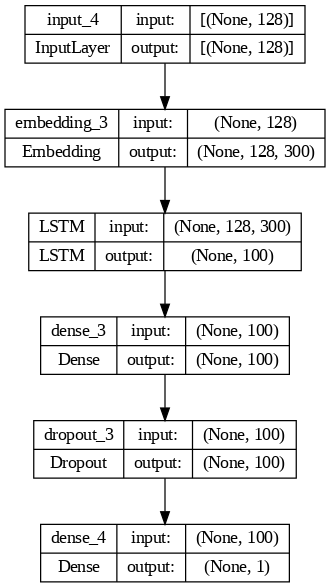

In [59]:
rnn_dim = 100
dense_layer_dims = [100]
dropout_rate = 0.5

rnn_model = build_rnn_model(rnn_dim,
                            dense_layer_dims,
                            dropout_rate,
                            embeddings_trainable=False)
keras.utils.plot_model(rnn_model, show_shapes=True, dpi=90)

In [60]:
rnn_history = rnn_model.fit(train_input,
                            train_labels,
                            validation_data=(test_input, test_labels),
                            batch_size=32,
                            epochs=5
                            )

Epoch 1/5
625/625 [==============================] - 8s 9ms/step - loss: 0.6691 - accuracy: 0.5949 - val_loss: 0.8567 - val_accuracy: 0.5056
Epoch 2/5
625/625 [==============================] - 5s 9ms/step - loss: 0.6334 - accuracy: 0.6410 - val_loss: 0.5471 - val_accuracy: 0.7402
Epoch 3/5
625/625 [==============================] - 5s 8ms/step - loss: 0.5247 - accuracy: 0.7555 - val_loss: 0.5418 - val_accuracy: 0.7214
Epoch 4/5
625/625 [==============================] - 5s 9ms/step - loss: 0.4900 - accuracy: 0.7699 - val_loss: 0.4715 - val_accuracy: 0.7838
Epoch 5/5
625/625 [==============================] - 5s 8ms/step - loss: 0.4771 - accuracy: 0.7761 - val_loss: 0.5046 - val_accuracy: 0.7898


Let's compare this to the CNN results:

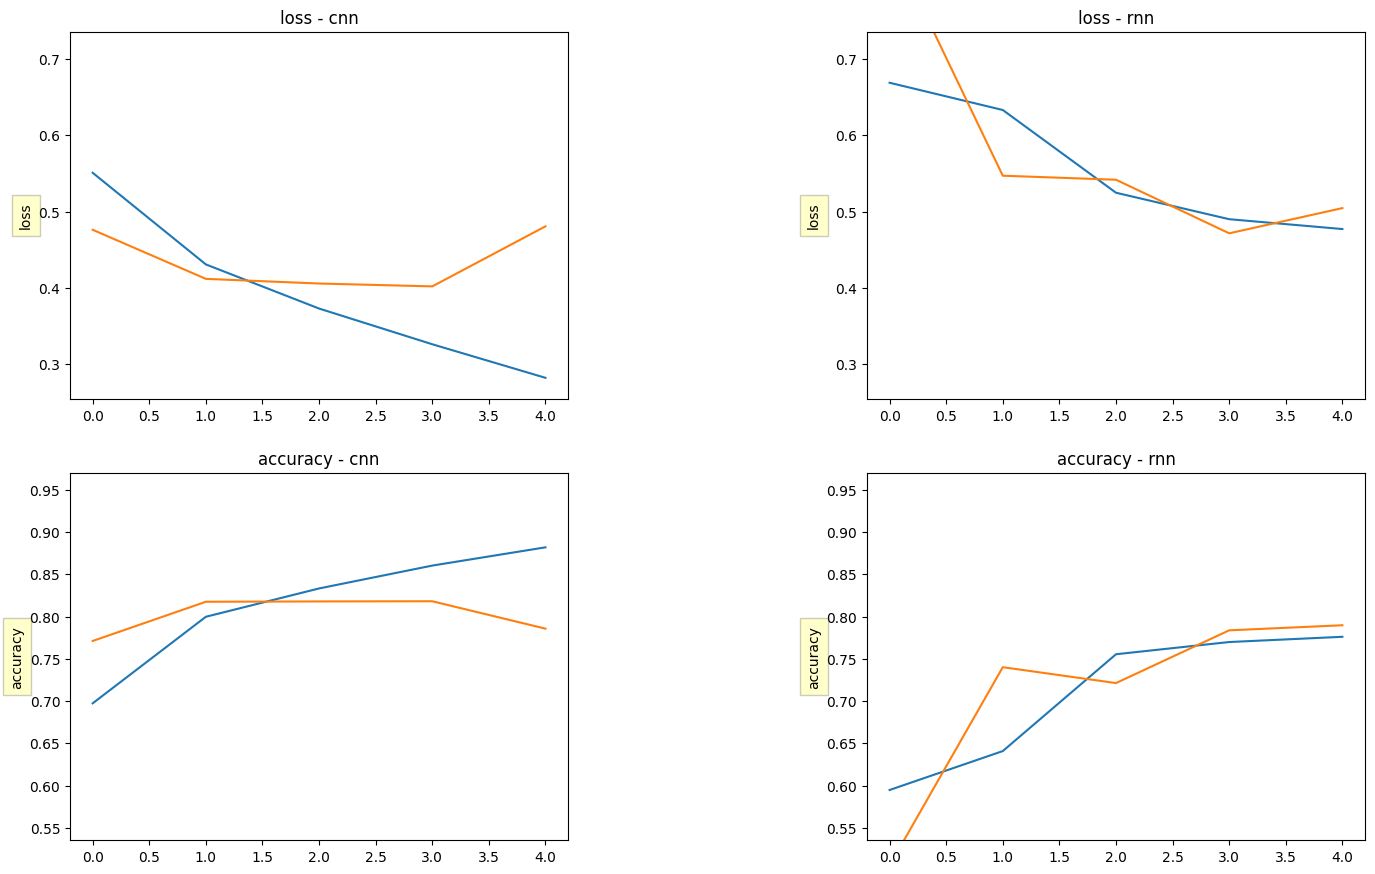

In [61]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          cnn_history, 
          rnn_history, 
          model_1_name='cnn',
          model_2_name='rnn')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

[Return to Top](#returnToTop)  
<a id = 'modelAttention'></a>

## 4. What about Attention?

Let us do a manual calculation with a simple set of queries and keys. (We'll use the keys as values as well, which is often done.)

In [62]:
test_query = np.array([[1., 2]])

test_keys_values = np.array([[-1., 1], [5, -2.]])

What do we get with a manual calculation?

[back to slides](https://docs.google.com/presentation/d/1QL96CoLle8cgbrUB3uWuZ9hpKQ-MavOsKss1HGon2zE/edit#slide=id.p44)

Let's compare that to the result of the Keras attention calculation: 

In [63]:
tf.keras.layers.Attention()([test_query, test_keys_values], return_attention_scores=True)

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 2. , -0.5]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5, 0.5]], dtype=float32)>)

Does that look right?

[Return to Top](#returnToTop)  
<a id = 'answers'></a>
## 5. Answers

**Question 3.4.2**:

The **Sequence Annotation Model** can model tasks like part of speech tagging or named entity tagging where a label must be assigned to each token.

The **Sequence to Vector Model** can model tasks like sentence  classification or can be used to generate a vector representing the text input that is then used by another model like an image generator.

The **Vector to Sequence Model** can model a task like image captioning where we pass a vector representation of an image into the model and it then generates a sequence of words in the caption.

The **Sequence to Sequence Model** (also known as an encoder-decoder model) can model a task like machine translation or summarization where you have an input text and we want to generate the appropriate corresponding output text.
